# 1. 필수 파일 설치 및 파일 경로 설정


In [3]:
# 1. 필수 라이브러리 및 NumPy 버전 호환성 설정
!pip install -q timm albumentations facenet-pytorch
!pip install "numpy<2.0"

# 2. 프로젝트 폴더 구조 생성
import os
os.makedirs('config', exist_ok=True)
os.makedirs('src', exist_ok=True)
os.makedirs('model', exist_ok=True)
os.makedirs('data', exist_ok=True)       # 대회(Target) 데이터용
os.makedirs('data_ffpp', exist_ok=True)  # FF++(Source) 데이터용
os.makedirs('test_data', exist_ok=True)

print("✅ 환경 설정 및 폴더 생성 완료!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [10]:
%%writefile download.py
# -*- coding: utf-8 -*-
""" Downloads FaceForensics++ and Deep Fake Detection public data release """
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join

# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original_youtube_videos': 'misc/downloaded_youtube_videos.zip',
    'original_youtube_videos_info': 'misc/downloaded_youtube_videos_info.zip',
    'original': 'original_sequences/youtube',
    'DeepFakeDetection_original': 'original_sequences/actors',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'DeepFakeDetection': 'manipulated_sequences/DeepFakeDetection',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceShifter': 'manipulated_sequences/FaceShifter',
    'FaceSwap': 'manipulated_sequences/FaceSwap',
    'NeuralTextures': 'manipulated_sequences/NeuralTextures'
    }
ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
                'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
                'NeuralTextures']
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-d', '--dataset', type=str, default='all',
                        help='Which dataset to download',
                        choices=list(DATASETS.keys()) + ['all']
                        )
    parser.add_argument('-c', '--compression', type=str, default='raw',
                        help='Which compression degree.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=None,
                        help='Select a number of videos number to download')
    parser.add_argument('--server', type=str, default='EU',
                        help='Server to download the data from.',
                        choices=SERVERS
                        )
    args = parser.parse_args()

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    if duration > 0:
        speed = int(progress_size / (1024 * duration))
    else:
        speed = 0
    if total_size > 0:
        percent = int(count * block_size * 100 / total_size)
    else:
        percent = 0
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        try:
            if report_progress:
                urllib.request.urlretrieve(url, out_file_tmp,
                                           reporthook=reporthook)
            else:
                urllib.request.urlretrieve(url, out_file_tmp)
            os.rename(out_file_tmp, out_file)
        except Exception as e:
            print(f"\nError downloading {url}: {e}")
            os.remove(out_file_tmp)
    else:
        tqdm.write('WARNING: skipping download of existing file ' + out_file)


def main(args):
    # TOS
    print('By running this script you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')
    # Google Colab 수정: input() 제거하여 자동 진행되도록 변경
    # print('Press any key to continue, or CTRL-C to exit.')
    # _ = input('')

    # Extract arguments
    c_datasets = [args.dataset] if args.dataset != 'all' else ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
                suffix = 'info'
            download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists
        try:
            if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
                filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
                if 'actors' in dataset_path:
                    filelist = filepaths['actors']
                else:
                    filelist = filepaths['DeepFakesDetection']
            elif 'original' in dataset_path:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist += pair
            else:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist.append('_'.join(pair))
                    if c_type != 'models':
                        filelist.append('_'.join(pair[::-1]))
        except Exception as e:
            print(f"Error fetching filelist: {e}")
            continue

        if num_videos is not None and num_videos > 0:
            print('Downloading the first {} videos'.format(num_videos))
            filelist = filelist[:num_videos]

        # Server and local paths
        dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
        dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)
        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                print('Skipping original masks.')
                continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)

if __name__ == "__main__":
    args = parse_args()
    main(args)

Writing download.py


In [12]:
# 1. 구글 드라이브 마운트 (이미 되어 있다면 패스)
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. 저장 경로 설정
OUTPUT_PATH = '/content/drive/MyDrive/FF_Data'

# 3. [Real Data] 진짜 영상 1000개 다운로드
print("🟢 1. Real(original) 데이터 1,000개 다운로드 시작...")
!python download.py {OUTPUT_PATH} \
    -d original \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

# 4. [Fake Data] 가짜 영상 1,000개 다운로드
print("\n🔴 2. Fake(Deepfakes) 데이터 1,000개 다운로드 시작...")
!python download.py {OUTPUT_PATH} \
    -d Deepfakes \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

print("\n✅ 전체 다운로드 완료! (총 2,000개)")
print(f"저장 경로: {OUTPUT_PATH}")

🟢 1. Real(original) 데이터 1,000개 다운로드 시작...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/original_sequences/youtube/c40/videos
100% 1000/1000 [22:41<00:00,  1.36s/it]

🔴 2. Fake(Deepfakes) 데이터 1,000개 다운로드 시작...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/manipulated_sequences/Deepfakes/c40/videos
100% 1000/1000 [22:42<00:00,  1.36s/it]

✅ 전체 다운로드 완료! (총 2,000개)
저장 경로: /content/drive/MyDrive/FF_Data


In [20]:
# 다운로드 받은 데이터 위치 확인하는 코드
import os
import glob

# 1. 구글 드라이브 확인
drive_path = '/content/drive/MyDrive/FF_Data'
colab_path = './data_ffpp'

print("🕵️ 데이터 위치 추적 중...")

# 구글 드라이브 검사
if os.path.exists(drive_path):
    files = glob.glob(os.path.join(drive_path, '**', '*.mp4'), recursive=True)
    print(f"✅ 구글 드라이브에서 발견됨! ({len(files)}개)")
    print(f"   경로: {drive_path}")
    TARGET_PATH = drive_path # 여기가 정답
else:
    print(f"❌ 구글 드라이브에 없음 ({drive_path})")
    TARGET_PATH = colab_path # 없으면 기본 경로 다시 시도

# 2. 만약 구글 드라이브에도 없다면?
if TARGET_PATH == colab_path:
    files = glob.glob(os.path.join(colab_path, '**', '*.mp4'), recursive=True)
    print(f"🧐 Colab 폴더 확인 결과: {len(files)}개 발견")

# 결론
if len(files) > 0:
    print(f"\n🎉 찾았다! 데이터는 여기에 있습니다: '{TARGET_PATH}'")
    print("이제 config.yaml의 경로를 수정합니다...")
else:
    print("\n🚨 비상! 어디에도 데이터가 없습니다. 다운로드가 실패했을 가능성이 높습니다.")

🕵️ 데이터 위치 추적 중...
✅ 구글 드라이브에서 발견됨! (2000개)
   경로: /content/drive/MyDrive/FF_Data

🎉 찾았다! 데이터는 여기에 있습니다: '/content/drive/MyDrive/FF_Data'
이제 config.yaml의 경로를 수정합니다...


# 2. 대회(Target) 데이터

In [21]:
%%writefile config/config.yaml
SEED: 42
# [핵심 변경 1] 이미지 크기 상향 (224 -> 384)
# 딥페이크의 미세한 노이즈를 잡기 위해 해상도를 높입니다.
IMG_SIZE: 384

# [핵심 변경 2] 배치 사이즈 하향 (32 -> 8 또는 16)
# 이미지가 커지고 모델이 무거워졌으므로, VRAM 폭발 방지를 위해 줄입니다.
# Colab T4 GPU 기준 8~12 정도가 안전합니다.
BATCH_SIZE: 16

EPOCHS: 7

# [핵심 변경 3] 학습률 미세 조정
# Swin 같은 Transformer 계열은 학습률에 민감합니다.
# 1e-4보다는 2e-5 ~ 5e-5 사이의 낮은 학습률이 안정적입니다.
LEARNING_RATE: 0.00003

# [강력 추천 모델] Swin Transformer (384px 버전)
# 어제 쓴 EfficientNet보다 문맥 파악 능력이 뛰어납니다.
MODEL_NAME: 'swin_base_patch4_window12_384'

DATA_PATH: '{TARGET_PATH}'
SAVE_PATH: './model/best_model_ffpp.pt'

Overwriting config/config.yaml


In [23]:
# 매칭이 잘 됫는지 확인하는 코드(업데이트 완료가 되면 다음코드 실행)
print(f"✅ config.yaml 업데이트 완료!")
print(f"   변경된 DATA_PATH: {TARGET_PATH}")

✅ config.yaml 업데이트 완료!
   변경된 DATA_PATH: /content/drive/MyDrive/FF_Data


# 3. 데이터셋 설정

In [24]:
%%writefile src/dataset.py
import cv2
import torch
import os
import random
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DeepfakeDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        ext = os.path.splitext(path)[1].lower()
        image = None

        # [핵심] 동영상 프레임 랜덤 추출 (학습 시 다양한 장면 학습)
        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            try:
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if frame_count > 1:
                    # 영상 길이 내에서 랜덤한 프레임 하나를 뽑습니다.
                    random_frame = random.randint(0, frame_count - 1)
                    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
                ret, frame = cap.read()
                cap.release()
                if ret:
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            except:
                image = None
        else:
            image = cv2.imread(path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 예외 처리: 검은 화면
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.labels is not None:
            return image, torch.tensor(self.labels[idx], dtype=torch.float32)
        else:
            return image

def get_transforms(img_size):
    # FF++ 데이터에 맞춘 강력한 증강 (압축 노이즈 등)
    train_aug = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.GaussNoise(p=0.2),
        A.Normalize(),
        ToTensorV2()
    ])
    valid_aug = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(),
        ToTensorV2()
    ])
    return train_aug, valid_aug

Overwriting src/dataset.py


# 4. 모델 설정

In [25]:
%%writefile src/models.py
import torch.nn as nn
import timm

class DeepfakeModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(DeepfakeModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)

    def forward(self, x):
        return self.model(x)

Overwriting src/models.py


# 5. 학습 코드 설정

In [26]:
%%writefile train.py
import os
import glob
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
from src.dataset import DeepfakeDataset, get_transforms
from src.models import DeepfakeModel

# Config 로드
with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

def train():
    # 1. 시드 고정
    torch.manual_seed(CFG['SEED'])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(CFG['SEED'])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🤖 Using Device: {device}")

    # 2. FF++ 데이터 검색
    print(f"📂 FF++ 데이터 검색 및 분류 중... ({CFG['DATA_PATH']})")
    all_files = []

    # 동영상 확장자 검색
    for ext in ['mp4', 'avi', 'mov']:
        all_files.extend(glob.glob(os.path.join(CFG['DATA_PATH'], '**', f'*.{ext}'), recursive=True))

    real_paths = []
    fake_paths = []

    # FF++ 폴더명 규칙에 따른 분류
    for path in all_files:
        lower = path.lower()
        if 'original_sequences' in lower:
            real_paths.append(path)
        elif 'manipulated_sequences' in lower:
            fake_paths.append(path)

    print(f"🔎 검색 결과 -> Real(Original): {len(real_paths)}개, Fake(Manipulated): {len(fake_paths)}개")

    if len(real_paths) == 0 or len(fake_paths) == 0:
        print("❌ 데이터를 찾지 못했습니다. 다운로드가 완료되었는지 확인해주세요.")
        return

    # 3. 데이터 밸런싱 (학습 효율을 위해)
    # FF++ 데이터가 많으므로, epoch당 사용할 데이터 수를 제한합니다 (각 20,000개).
    # 전체를 다 쓰고 싶으면 target_len 부분을 주석 처리하세요.
    target_len = min(len(real_paths), len(fake_paths), 20000)

    random.shuffle(real_paths)
    random.shuffle(fake_paths)

    real_paths = real_paths[:target_len]
    fake_paths = fake_paths[:target_len]

    print(f"🚀 이번 학습에 사용할 데이터 -> Real: {len(real_paths)}, Fake: {len(fake_paths)}")

    all_paths = real_paths + fake_paths
    labels = [0]*len(real_paths) + [1]*len(fake_paths)

    # Split
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_paths, labels, test_size=0.2, random_state=CFG['SEED'], stratify=labels
    )

    # Loader
    train_tf, valid_tf = get_transforms(CFG['IMG_SIZE'])
    train_loader = DataLoader(DeepfakeDataset(train_paths, train_labels, train_tf),
                              batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=2)
    val_loader = DataLoader(DeepfakeDataset(val_paths, val_labels, valid_tf),
                            batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

    # Model
    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=True).to(device)

    # Optimizer & Scheduler
    optimizer = optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    criterion = nn.BCEWithLogitsLoss()

    # 저장 폴더
    save_dir = os.path.dirname(CFG['SAVE_PATH'])
    if not os.path.exists(save_dir): os.makedirs(save_dir)

    best_loss = float('inf')

    # Train Loop
    print("🔥 Start Training on FaceForensics++...")
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = 0

        for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
            imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)

            # Label Smoothing (LogLoss 방어)
            smoothing_value = 0.05
            targets_smooth = targets * (1 - smoothing_value) + 0.5 * smoothing_value

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets_smooth)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), CFG['SAVE_PATH'])
            print(f"✅ Best Model Saved! ({val_loss:.4f})")

if __name__ == '__main__':
    train()

Overwriting train.py


In [30]:
## 밑에 train.py가 실행이 안되면 이 코드를 누르기.
import os
import yaml
import glob

# 1. 데이터가 실제로 있는 곳 찾기 (자동 탐지)
search_paths = [
    '/content/drive/MyDrive/FF_Data',  # 구글 드라이브 (1순위)
    './data_ffpp',                     # 로컬 폴더 (2순위)
    './data'                           # 기타 (3순위)
]

found_path = None
for path in search_paths:
    if os.path.exists(path):
        # mp4 파일이 하나라도 있는지 확인
        if len(glob.glob(os.path.join(path, '**', '*.mp4'), recursive=True)) > 0:
            found_path = path
            break

if found_path:
    print(f"✅ 데이터를 찾았습니다! 경로: {found_path}")
else:
    print("❌ 데이터를 찾지 못했습니다. 우선 기본 경로('./data_ffpp')로 설정합니다.")
    print("   (다운로드가 안 됐다면 다운로드부터 다시 해야 합니다.)")
    found_path = './data_ffpp'

# 2. config.yaml 파일 강제 재생성
config_content = {
    'SEED': 42,
    'IMG_SIZE': 384,             # 고성능 해상도
    'BATCH_SIZE': 16,             # VRAM 안전값
    'EPOCHS': 7,
    'LEARNING_RATE': 0.00003,    # 정교한 학습률
    'MODEL_NAME': 'swin_base_patch4_window12_384', # 고성능 모델
    'DATA_PATH': found_path,     # <--- 찾은 경로 자동 주입
    'SAVE_PATH': './model/best_model_ffpp.pt'
}

# 폴더가 없으면 생성
os.makedirs('config', exist_ok=True)

# 파일 쓰기
with open('config/config.yaml', 'w') as f:
    yaml.dump(config_content, f)

print("\n📄 config/config.yaml 파일이 복구되었습니다.")
print("-" * 30)
with open('config/config.yaml', 'r') as f:
    print(f.read())
print("-" * 30)
print("🚀 이제 다시 !python train.py를 실행해보세요!")

✅ 데이터를 찾았습니다! 경로: /content/drive/MyDrive/FF_Data

📄 config/config.yaml 파일이 복구되었습니다.
------------------------------
BATCH_SIZE: 16
DATA_PATH: /content/drive/MyDrive/FF_Data
EPOCHS: 7
IMG_SIZE: 384
LEARNING_RATE: 3.0e-05
MODEL_NAME: swin_base_patch4_window12_384
SAVE_PATH: ./model/best_model_ffpp.pt
SEED: 42

------------------------------
🚀 이제 다시 !python train.py를 실행해보세요!


In [31]:
!python train.py

🤖 Using Device: cuda
📂 FF++ 데이터 검색 및 분류 중... (/content/drive/MyDrive/FF_Data)
🔎 검색 결과 -> Real(Original): 1000개, Fake(Manipulated): 1000개
🚀 이번 학습에 사용할 데이터 -> Real: 1000, Fake: 1000
/content/src/dataset.py:62: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
🔥 Start Training on FaceForensics++...
Epoch 1 Train: 100% 100/100 [08:51<00:00,  5.32s/it]
Epoch 1 | Train Loss: 0.6711 | Val Loss: 0.4226
✅ Best Model Saved! (0.4226)
Epoch 2 Train: 100% 100/100 [09:07<00:00,  5.47s/it]
Epoch 2 | Train Loss: 0.4960 | Val Loss: 0.2910
✅ Best Model Saved! (0.2910)
Epoch 3 Train: 100% 100/100 [08:25<00:00,  5.05s/it]
Epoch 3 | Train 

# 6. TEST용 파일 설치

In [34]:
# [Cell] 구글 드라이브 마운트 및 지정된 6개 확장자 파일 추출
import os
import shutil
import glob
from google.colab import drive

# 1. 기존 폴더 정리 (깨끗하게 초기화)
if os.path.exists('./test_data'):
    shutil.rmtree('./test_data')
if os.path.exists('./temp_test'):
    shutil.rmtree('./temp_test')

# 2. 구글 드라이브 마운트
drive.mount('/content/drive')

# 3. 경로 설정 (사용자님 드라이브 경로)
drive_path = '/content/drive/MyDrive/딥페이크 AI 대회/test.zip'

if os.path.exists(drive_path):
    print(f"✅ 구글 드라이브에서 파일을 찾았습니다! ({os.path.getsize(drive_path)/1024/1024:.2f} MB)")

    # 압축 풀기
    print("📦 압축 해제 중... (잠시만 기다려주세요)")
    !unzip -q "{drive_path}" -d ./temp_test

    # 4. 파일 이동 (지정해주신 6개 확장자만 타겟팅)
    os.makedirs('./test_data', exist_ok=True)

    # 검색할 확장자 리스트 (대소문자 모두 포함하도록 설정)
    target_extensions = ['jfif', 'jpeg', 'jpg', 'mov', 'mp4', 'png']
    search_patterns = []

    # 예: *.jpg 와 *.JPG 를 모두 검색 리스트에 추가
    for ext in target_extensions:
        search_patterns.append(f'*.{ext.lower()}')
        search_patterns.append(f'*.{ext.upper()}')

    print(f"검색할 확장자들: {search_patterns}")

    all_files = []
    for pattern in search_patterns:
        # 재귀적으로 폴더 깊숙한 곳까지 검색
        found = glob.glob(f'./temp_test/**/{pattern}', recursive=True)
        all_files.extend(found)

    print(f"총 {len(all_files)}개의 파일을 발견했습니다. 이동을 시작합니다...")

    # 파일 이동 실행
    for file in all_files:
        try:
            # 파일명이 겹칠 경우를 대비해 덮어쓰기 혹은 건너뛰기
            shutil.move(file, './test_data')
        except shutil.Error:
            print(f"⚠️ 중복 파일 존재: {os.path.basename(file)} (건너뜀)")
        except Exception as e:
            print(f"❌ 이동 실패: {file} - {e}")

    # 최종 확인
    final_count = len(os.listdir('./test_data'))
    print(f"🎉 성공! ./test_data 폴더 안에 총 {final_count}개의 파일이 준비되었습니다.")

    # 임시 폴더 삭제
    shutil.rmtree('./temp_test')

else:
    print(f"❌ '{drive_path}' 경로에 파일이 없습니다.")
    print("구글 드라이브 경로와 파일명을 다시 한번 확인해주세요.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 구글 드라이브에서 파일을 찾았습니다! (1808.57 MB)
📦 압축 해제 중... (잠시만 기다려주세요)
검색할 확장자들: ['*.jfif', '*.JFIF', '*.jpeg', '*.JPEG', '*.jpg', '*.JPG', '*.mov', '*.MOV', '*.mp4', '*.MP4', '*.png', '*.PNG']
총 500개의 파일을 발견했습니다. 이동을 시작합니다...
🎉 성공! ./test_data 폴더 안에 총 500개의 파일이 준비되었습니다.


# 7. 추론 코드 저장 및 실행

In [37]:
%%writefile inference.py
import torch
import torch.nn as nn
import cv2
import os
import glob
import pandas as pd
import numpy as np
import yaml
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import timm

# 1. 설정 로드 (어떤 모델 구조로 학습했는지 확인)
with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

print(f"🤖 Model Architecture: {CFG['MODEL_NAME']}")

# 2. 데이터셋 클래스 (추론용)
class DeepfakeInferenceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        ext = os.path.splitext(path)[1].lower()
        image = None

        # 동영상 처리: 추론 때는 '중간 프레임'을 하나 뽑아서 검사합니다.
        # (랜덤이 아니라 고정된 프레임을 써야 결과가 일정함)
        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            try:
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                # 영상의 정중앙 프레임 추출 (가장 안정적)
                if frame_count > 1:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count // 2)

                ret, frame = cap.read()
                cap.release()
                if ret:
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            except:
                image = None
        else:
            # 이미지 파일
            image = cv2.imread(path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 읽기 실패 시 검은 화면
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, path

# 3. 모델 클래스
class DeepfakeModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super(DeepfakeModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)

    def forward(self, x):
        return self.model(x)

# 4. 추론 실행 함수
def inference():
    # 학습 코드에서 저장한 모델 파일명
    MODEL_PATH = './model/best_model_ffpp.pt'

    # 테스트할 파일들이 있는 폴더
    # (없으면 자동으로 ./test_data 폴더를 만들고 확인합니다)
    SEARCH_DIR = './test_data'
    if not os.path.exists(SEARCH_DIR):
        os.makedirs(SEARCH_DIR)
        print(f"⚠️ '{SEARCH_DIR}' 폴더가 비어있습니다. 테스트할 영상이나 사진을 넣어주세요!")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 파일 검색
    print(f"📂 테스트 파일 검색 중... ({SEARCH_DIR})")
    test_files = []
    for ext in ['mp4', 'avi', 'mov', 'jpg', 'jpeg', 'png', 'jfif']:
        test_files.extend(glob.glob(os.path.join(SEARCH_DIR, '**', f'*.{ext}'), recursive=True))
        test_files.extend(glob.glob(os.path.join(SEARCH_DIR, '**', f'*.{ext.upper()}'), recursive=True))

    # 중복 제거
    test_files = sorted(list(set(test_files)))

    if len(test_files) == 0:
        print("❌ 테스트할 파일이 없습니다. ./test_data 폴더에 파일을 넣어주세요.")
        return

    print(f"✅ 발견된 파일: {len(test_files)}개")

    # 모델 로드
    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=False)

    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"🎉 학습된 모델 로드 성공! ({MODEL_PATH})")
    else:
        print(f"❌ 학습된 모델 파일이 없습니다: {MODEL_PATH}")
        print("먼저 train.py를 실행해서 모델을 학습시켜주세요.")
        return

    model.to(device)
    model.eval()

    # 데이터 로더
    transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.Normalize(),
        ToTensorV2()
    ])

    dataset = DeepfakeInferenceDataset(test_files, transform=transform)
    loader = DataLoader(dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

    preds = []
    filenames = []

    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc="Inference"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

            if np.ndim(probs) == 0: probs = [probs]

            preds.extend(probs)
            filenames.extend([os.path.basename(p) for p in paths])

    # 결과 저장
    df = pd.DataFrame({'filename': filenames, 'prob': preds})
    df.to_csv('./submission.csv', index=False)

    print("\n✅ 결과 저장 완료: ./submission.csv")
    print(df.head(10)) # 상위 10개 출력

if __name__ == '__main__':
    inference()

Overwriting inference.py


In [38]:
!python inference.py

🤖 Model Architecture: swin_base_patch4_window12_384
📂 테스트 파일 검색 중... (./test_data)
✅ 발견된 파일: 500개
🎉 학습된 모델 로드 성공! (./model/best_model_ffpp.pt)
Inference: 100% 32/32 [02:08<00:00,  4.00s/it]

✅ 결과 저장 완료: ./submission.csv
       filename      prob
0  TEST_000.mp4  0.022632
1  TEST_001.jpg  0.024889
2  TEST_002.mp4  0.063464
3  TEST_003.mp4  0.958444
4  TEST_004.jpg  0.009578
5  TEST_005.mp4  0.015373
6  TEST_006.mp4  0.016907
7  TEST_007.jpg  0.509016
8  TEST_008.jpg  0.060726
9  TEST_009.png  0.045415


In [ ]:
import pandas as pd
import numpy as np

# 1. 기존 제출 파일 읽기
df = pd.read_csv('./submission.csv')

print("보정 전 통계:")
print(df['prob'].describe())

# 2. 값 보정 (Clipping)
# 0.0 -> 0.05 (혹시 모르니 5% 여지 남김)
# 1.0 -> 0.95 (혹시 모르니 5% 여지 남김)
# 너무 극단적인 0과 1을 없애서, 틀렸을 때의 페널티를 줄입니다.
df['prob'] = df['prob'].clip(0.05, 0.95)

print("\n보정 후 통계:")
print(df['prob'].describe())

# 3. 저장
df.to_csv('./submission_clipped.csv', index=False)
print("\n✅ 'submission_clipped.csv' 저장 완료! 이 파일을 제출해보세요.")

보정 전 통계:
count    5.000000e+02
mean     4.565116e-02
std      1.749011e-01
min      4.664486e-12
25%      1.256258e-05
50%      1.719705e-04
75%      2.161191e-03
max      9.999986e-01
Name: prob, dtype: float64

보정 후 통계:
count    500.000000
mean       0.087931
std        0.158540
min        0.050000
25%        0.050000
50%        0.050000
75%        0.050000
max        0.950000
Name: prob, dtype: float64

✅ 'submission_clipped.csv' 저장 완료! 이 파일을 제출해보세요.


📄 CSV 로드 완료: 500개 데이터
🗺️ 파일 위치 지도를 만드는 중... (탐색 경로: /content/test_data)
✅ 파일 지도 완성! 500개의 파일을 찾았습니다.

🟢 모델이 [Real(0)]이라고 확신한 데이터


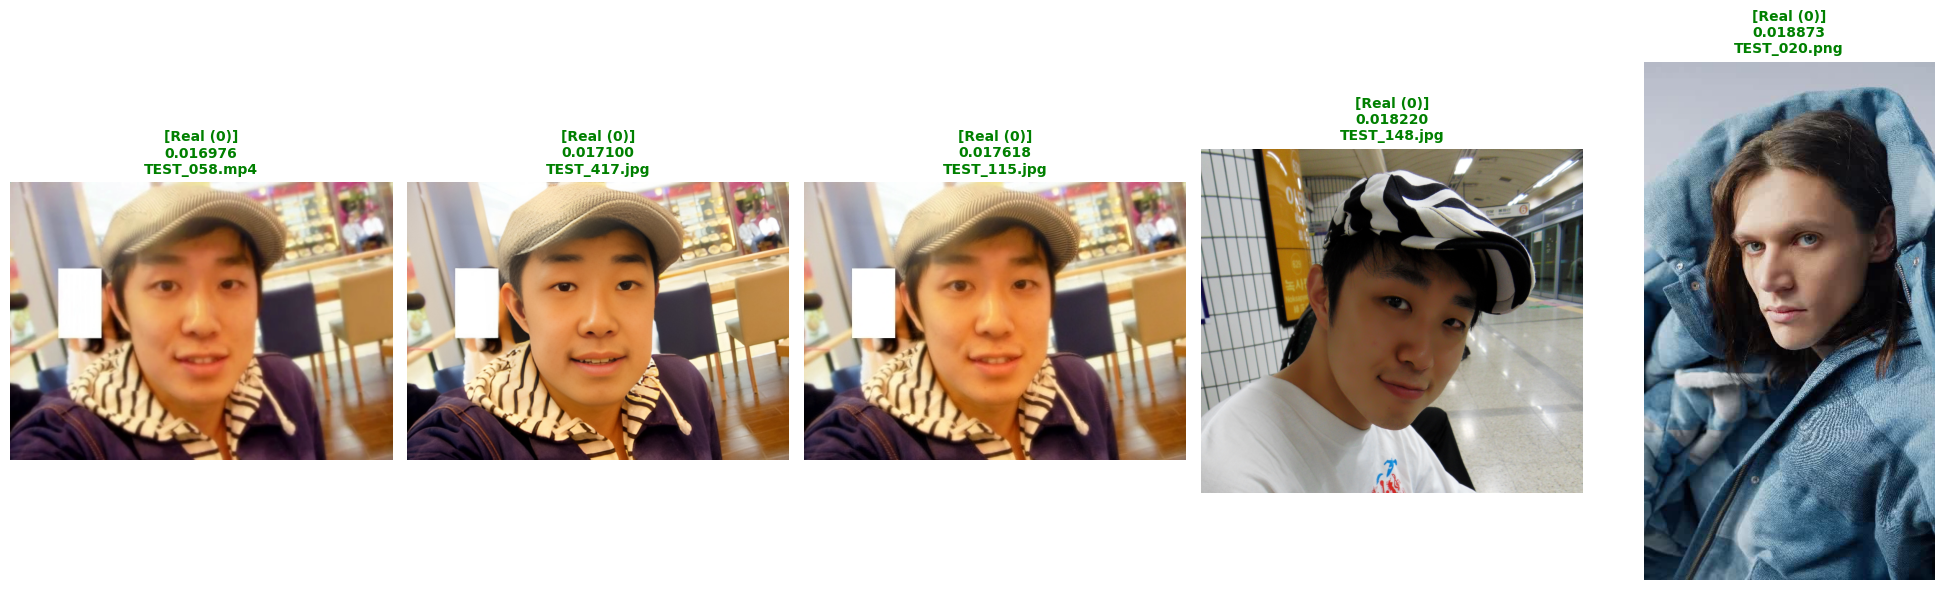


🔴 모델이 [Fake(1)]라고 확신한 데이터


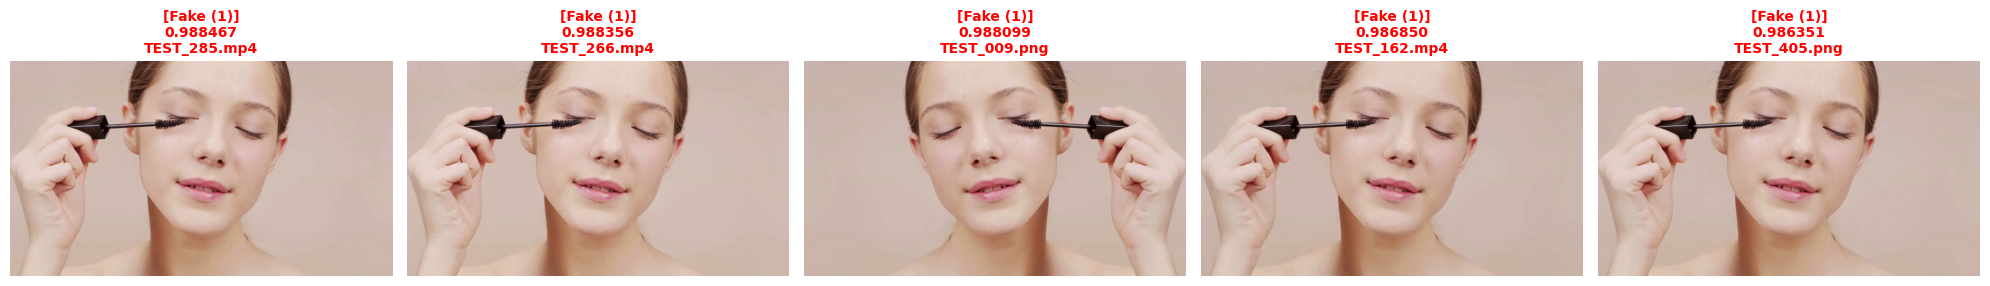

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

# 1. 결과 파일 읽기
if not os.path.exists('./submission.csv'):
    print("❌ 에러: 'submission.csv' 파일이 없습니다. 추론(Inference)을 먼저 실행해주세요.")
else:
    df = pd.read_csv('./submission.csv')
    print(f"📄 CSV 로드 완료: {len(df)}개 데이터")

    # 2. [핵심] 파일 위치 지도 만들기 (대상 폴더: /test_data)
    # 요청하신 대로 '/test_data' 폴더를 탐색합니다.
    SEARCH_DIR = '/content/test_data'

    print(f"🗺️ 파일 위치 지도를 만드는 중... (탐색 경로: {SEARCH_DIR})")

    file_map = {}
    if os.path.exists(SEARCH_DIR):
        for root, dirs, files in os.walk(SEARCH_DIR):
            for f in files:
                # 파일명(key) -> 전체경로(value) 매핑
                file_map[f] = os.path.join(root, f)
        print(f"✅ 파일 지도 완성! {len(file_map)}개의 파일을 찾았습니다.")
    else:
        print(f"⚠️ 경고: '{SEARCH_DIR}' 폴더가 존재하지 않습니다. 경로를 다시 확인해주세요.")

    # 3. 미디어 읽기 함수
    def read_media(path):
        ext = os.path.splitext(path)[1].lower()
        # 동영상 처리
        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            cap = cv2.VideoCapture(path)
            ret, frame = cap.read()
            cap.release()
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if ret else None
        # 이미지 처리
        else:
            img = cv2.imread(path)
            return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None

    # 4. 시각화 함수
    def show_top_samples_final(df, n=5, ascending=True):
        sorted_df = df.sort_values(by='prob', ascending=ascending).head(n)

        plt.figure(figsize=(20, 6))
        found_cnt = 0

        for i, (idx, row) in enumerate(sorted_df.iterrows()):
            filename = row['filename']

            # 지도에서 경로 찾기
            if filename in file_map:
                full_path = file_map[filename]
            else:
                # 맵에 없으면 혹시 모르니 직접 경로 결합 시도
                full_path = os.path.join(SEARCH_DIR, filename)
                if not os.path.exists(full_path):
                    continue # 진짜 없음

            # 읽기
            img = read_media(full_path)
            if img is None: continue

            found_cnt += 1
            plt.subplot(1, n, found_cnt)
            plt.imshow(img)

            label = "Real (0)" if ascending else "Fake (1)"
            color = "green" if ascending else "red"
            plt.title(f"[{label}]\n{row['prob']:.6f}\n{filename}", color=color, fontsize=10, fontweight='bold')
            plt.axis('off')

        if found_cnt == 0:
            print(f"😭 이미지를 하나도 못 띄웠습니다. '{SEARCH_DIR}' 안에 파일 이름이 일치하는 파일이 있는지 확인해주세요.")
        else:
            plt.tight_layout()
            plt.show()

    print("\n" + "="*50)
    print("🟢 모델이 [Real(0)]이라고 확신한 데이터")
    show_top_samples_final(df, n=5, ascending=True)

    print("\n" + "="*50)
    print("🔴 모델이 [Fake(1)]라고 확신한 데이터")
    show_top_samples_final(df, n=5, ascending=False)